## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-dark")


In [ ]:
sweden = pd.read_csv("wid_all_data/WID_data_SE.CSV", sep = ";")
#sweden
sweden_shares = sweden[sweden["variable"].str.contains(r'^s.*', regex=True)]


,country,variable,percentile,year,value,age,pop
12154,SE,sfiinct992,p99p99.5,1903,0.0450,992,t
12155,SE,sfiinct992,p99p99.5,1907,0.0486,992,t
12156,SE,sfiinct992,p99p99.5,1911,0.0433,992,t
12157,SE,sfiinct992,p99p99.5,1912,0.0460,992,t
12158,SE,sfiinct992,p99p99.5,1916,0.0507,992,t
...,...,...,...,...,...,...,...
293374,SE,sptincj992,p9p100,2018,0.9973,992,j
293375,SE,sptincj992,p9p100,2019,0.9973,992,j
293376,SE,sptincj992,p9p100,2020,0.9974,992,j
293377,SE,sptincj992,p9p100,2021,0.9975,992,j


In order to narrow the scope of analysis I have decided to look only at the variables representing shares of quantities. These have the added advantage of being in the same units. The definitions of the quantities being measured is the following:

1. **Post-tax disposable income:** Pre-tax income-Taxes on production (net)-Current taxes on income and wealth + Social assistance benefits in cash
2. **Post-tax national income:** Post-tax disposable income + Public spending
3. **Fiscal income:** [Fiscal labour income [total fiscal income ranking]]+[Fiscal capital income [total fiscal income ranking]]
4. **Net personal wealth:s** [Personal non-financial assets]+[Personal financial assets]-[Personal debt]

Even with this reduced scope, the route of analysis seems non-obvious. In principle our feature space is the 7-dimensional unit hypercube. However, since the population groups described by the percentiles is different for each variable, an analysis which simply compares the relative status of percentiles across **all** variables may be difficult to interpret.

However, this difficulty in interpretability may not be a problem. If the shares of 

Another problem is that the observations for different percentiles are obviously not independent.



In [20]:
sweden_metadata = pd.read_csv("wid_all_data/WID_metadata_SE.CSV", sep=";")
#sweden_metadata
sweden_shares_metadata = sweden_metadata[
    sweden_metadata["variable"].str.contains(r"^s.*", regex=True)
]
sweden_shares_metadata

,country,variable,age,pop,countryname,shortname,simpledes,technicaldes,shorttype,longtype,shortpop,longpop,shortage,longage,unit,source,method,extrapolation,data_points
1194,SE,scaincj992,992,j,Sweden,Post-tax disposable income,Post-tax private income corresponds to all sou...,Post-tax disposable income=Pre-tax income-Taxe...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,Adults,The population is comprised of individuals ove...,share,Main Paper: [URL][URL_LINK]https://wid.world/d...,Summary of data construction by year (see sour...,"[[2018, 2021]]",NaN
1195,SE,sdiincj992,992,j,Sweden,Post-tax national income,Post-tax national income is the sum of primary...,[Post-tax national income]=[Post-tax disposabl...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,Adults,The population is comprised of individuals ove...,share,Main Paper: [URL][URL_LINK]https://wid.world/d...,Summary of data construction by year (see sour...,"[[2018, 2022]]",NaN
1196,SE,sfiinct992,992,t,Sweden,Fiscal income,Fiscal income is defined as the sum of all inc...,[Fiscal income ]=[Fiscal labour income [total ...,Share,Income or wealth shares. When the associated p...,tax unit,The base unit is the tax unit defined by natio...,Adults,The population is comprised of individuals ove...,share,"Roine, Jesper and Waldenström, Daniel (2010). ...",The series includes social benefits and capita...,NaN,NaN
1197,SE,shwealj992,992,j,Sweden,Net personal wealth,Net personal wealth is the total value of non...,[Net personal wealth]=[Personal non-financial ...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,Adults,The population is comprised of individuals ove...,share,[URL][URL_LINK]http://wordpress.wid.world/docu...,NaN,NaN,NaN
1198,SE,spllinf992,992,f,Sweden,Pre-tax labor income [pre-tax labor income ran...,Pre-tax labor income [pre-tax labor income ran...,Pre-tax labor income [pre-tax labor income ran...,Share,Income or wealth shares. When the associated p...,female,The population looked at is comprised of femal...,Adults,The population is comprised of individuals ove...,share,[URL][URL_LINK]http://wordpress.wid.world/docu...,The age of the adult population is 15 years an...,NaN,NaN
1199,SE,sptincj992,992,j,Sweden,Pre-tax national income,Pre-tax national income is the sum of all pre...,Pre-tax national income =Pre-tax labor income ...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,Adults,The population is comprised of individuals ove...,share,Main Paper: [URL][URL_LINK]https://wid.world/d...,Summary of data construction by year (see sour...,"[[1820, 1934], [2018, 2022]]",NaN
1200,SE,sptincj999,999,j,Sweden,Pre-tax national income,Pre-tax national income is the sum of all pre...,Pre-tax national income =Pre-tax labor income ...,Share,Income or wealth shares. When the associated p...,equal-split adults,The base unit is the individual (rather than t...,All Ages,The population is comprised of individuals of ...,share,Main Paper: [URL][URL_LINK]https://wid.world/d...,Summary of data construction by year (see sour...,"[[1820, 1934], [2018, 2022]]",NaN


In [34]:
sweden_shares_metadata["technicaldes"][1197]

'[Net personal wealth]=[Personal non-financial assets]+[Personal financial assets]-[Personal debt]'

In [15]:
sweden["variable"].unique()

array(['ehfcari999', 'ehfghdi999', 'ehfghgi999', ..., 'xlcuspi999',
       'thwealj992', 'tptincj992'], dtype=object)

In [26]:
sweden_shares[
    (sweden_shares["year"] > 2000) + (sweden_shares["variable"] == "sfiinct992")
]

,country,variable,percentile,year,value,age,pop
12154,SE,sfiinct992,p99p99.5,1903,0.0450,992,t
12155,SE,sfiinct992,p99p99.5,1907,0.0486,992,t
12156,SE,sfiinct992,p99p99.5,1911,0.0433,992,t
12157,SE,sfiinct992,p99p99.5,1912,0.0460,992,t
12158,SE,sfiinct992,p99p99.5,1916,0.0507,992,t
...,...,...,...,...,...,...,...
293374,SE,sptincj992,p9p100,2018,0.9973,992,j
293375,SE,sptincj992,p9p100,2019,0.9973,992,j
293376,SE,sptincj992,p9p100,2020,0.9974,992,j
293377,SE,sptincj992,p9p100,2021,0.9975,992,j


<Axes: xlabel='year', ylabel='value'>

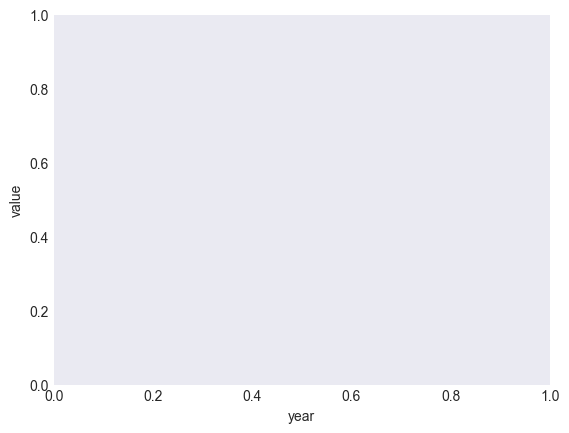

In [29]:
sns.lineplot(
    sweden_shares[(sweden_shares["year"]>2000) * (sweden_shares["variable"] == "sfiincj992")], y="value", x="year", hue = "percentile"
)